In [70]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.models.segmentation import deeplabv3_resnet101
from PIL import Image
import os
import glob
import numpy as np
import random
from einops import rearrange
import torch.nn.functional as F

In [71]:
class SementicSegmentationDrone(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, tile_size=512):
        self.images = sorted(glob.glob(os.path.join(image_dir, "*.jpg")))
        self.masks = sorted(glob.glob(os.path.join(mask_dir, "*.png")))
        self.transform = transform
        self.tile_size = tile_size

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        mask = Image.open(self.masks[idx])

        image = image.resize((self.tile_size, self.tile_size))
        mask = mask.resize((self.tile_size, self.tile_size), Image.NEAREST)

        mask = np.array(mask)

        if image.size[0] > self.tile_size or image.size[1] > self.tile_size:
            image_tiles, mask_tiles = self.split_into_tiles(image, mask)
            idx_tile = random.randint(0, len(image_tiles) - 1)
            image, mask = image_tiles[idx_tile], mask_tiles[idx_tile]

        if self.transform:
            image = self.transform(image)
            mask = torch.tensor(mask, dtype=torch.long)

        return image, mask
    
    def split_into_tiles(self, image, mask):
        image_width, image_height = image.size
        image_tiles = []
        mask_tiles = []

        for i in range(0, image_width, self.tile_size):
            for j in range(0, image_height, self.tile_size):
                image_tile = image.crop((i, j, min(i+self.tile_size, image_width), min(j+self.tile_size, image_height)))
                mask_pil = Image.fromarray(mask) 
                mask_tile = mask_pil.crop((i, j, min(i+self.tile_size, image_width), min(j+self.tile_size, image_height)))
                image_tiles.append(image_tile)
                mask_tiles.append(np.array(mask_tile))

        return image_tiles, mask_tiles

In [72]:
class TransformerBlock(nn.Module):
    def __init__(self, dim, heads=4, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(dim)
        self.ff = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim)
        )
        self.norm2 = nn.LayerNorm(dim)

    def forward(self, x):
        attn_out, _  = self.attn(x, x, x)
        x = self.norm1(x + attn_out)
        x = self.norm2(x + self.ff(x))
        return x

In [73]:
class HybridDeepLabV3(nn.Module):
    def __init__(self, num_classes=24):
        super().__init__()
        self.model = deeplabv3_resnet101(pretrained=False, weights_backbone=None)
        self.model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)

        # Add transformer block after backbone feature map.
        self.transformer = TransformerBlock(dim=256, heads=4)

    def forward(self, x):
        features = self.model.backbone(x)['out']
        features = self.model.classifier[0](features)

        # Transformer expects flattened spatial dim.
        B, C, H, W = features.shape
        x_flat = rearrange(features, 'b c h w -> b (h w) c')
        x_flat = self.transformer(x_flat)
        x_trans = rearrange(x_flat, 'b (h w) c -> b c h w', h=H, w=W)

        # Upsample the result to match the target size (512x512)
        x_trans = F.interpolate(x_trans, size=(512, 512), mode='bilinear', align_corners=False)

        # Manually apply each classifier layer after the transformer
        x = self.model.classifier[1](x_trans)  # Apply the second classifier layer
        x = self.model.classifier[2](x)       # Apply the third classifier layer
        x = self.model.classifier[3](x)       # Apply the fourth classifier layer
        x = self.model.classifier[4](x)       # Apply the final classifier layer

        return {'out': x}

In [74]:
directory = {
    "train_images": "advanced_data/x_train",
    "train_masks": "advanced_data/y_train",
    "val_images": "advanced_data/x_valid",
    "val_masks": "advanced_data/y_valid",
    "test_images": "advanced_data/x_test",
    "test_masks": "advanced_data/y_test"
}

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data = SementicSegmentationDrone(directory["train_images"], directory["train_masks"], transform=transform, tile_size=512)
valid_data = SementicSegmentationDrone(directory["val_images"], directory["val_masks"], transform=transform, tile_size=512)
test_data = SementicSegmentationDrone(directory["test_images"], directory["test_masks"], transform=transform, tile_size=512)

train_dataloader = DataLoader(train_data, batch_size=4, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=4, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=4, shuffle=False)

In [75]:
# Initialize Model and Load Weights.
model = HybridDeepLabV3(num_classes=24)

# Get the current state_dict of the model
state_dict = model.state_dict()

# Create a new state_dict with corrected keys for the transformer
new_state_dict = {}

for key, value in state_dict.items():
    # Correct the transformer-related keys by removing 'model.' from the start
    if key.startswith('model.transformer'):
        new_key = key.replace('model.', '')  # Remove 'model.' from the key
    else:
        new_key = key  # Otherwise, keep the key as is
    
    new_state_dict[new_key] = value

# Load the updated state_dict into your model
missing, unexpected = model.load_state_dict(new_state_dict, strict=False)

# Move the model to the appropriate device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Set the model to evaluation mode.
model.eval()

HybridDeepLabV3(
  (model): DeepLabV3(
    (backbone): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [76]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [77]:
epochs = 10
for epoch in range(epochs):
    model.train()
    run_loss = 0.0

    for images, masks in train_dataloader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()

        outputs = model(images)['out']

        loss = criterion(outputs, masks)
        loss.backward()

        optimizer.step()

        run_loss += loss.item()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {run_loss/len(train_dataloader)}')

    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for images, masks in valid_dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            valid_loss += loss.item()

    print(f'Validation Loss after Epoch {epoch+1}: {valid_loss/len(valid_dataloader)}')

Epoch 1/10, Loss: 2.216509943349021
Validation Loss after Epoch 1: 1.873415893316269
Epoch 2/10, Loss: 1.7881831543786184
Validation Loss after Epoch 2: 1.6225296974182128
Epoch 3/10, Loss: 1.7306454820292336
Validation Loss after Epoch 3: 1.5502270132303237
Epoch 4/10, Loss: 1.6451885768345424
Validation Loss after Epoch 4: 1.6073563516139984
Epoch 5/10, Loss: 1.5812611860888346
Validation Loss after Epoch 5: 1.7091812998056413
Epoch 6/10, Loss: 1.5848952089037214
Validation Loss after Epoch 6: 1.9755428194999696
Epoch 7/10, Loss: 1.5135409082685198
Validation Loss after Epoch 7: 1.358717456459999
Epoch 8/10, Loss: 1.421155391420637
Validation Loss after Epoch 8: 1.5959660559892654
Epoch 9/10, Loss: 1.44061872618539
Validation Loss after Epoch 9: 1.5104337155818939
Epoch 10/10, Loss: 1.4245614835194178
Validation Loss after Epoch 10: 1.308154249191284


In [78]:
def calculate_accuracy(preds, labels):
    preds = torch.argmax(preds, dim=1)
    correct = (preds == labels).float()
    return correct.sum() / correct.numel()

model.eval()
valid_loss = 0.0
valid_acc = 0.0

with torch.no_grad():
    for images, masks in valid_dataloader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        valid_loss += loss.item()

        acc = calculate_accuracy(outputs, masks)
        valid_acc += acc.item()

avg_val_loss = valid_loss / len(valid_dataloader)
avg_val_acc = valid_acc / len(valid_dataloader)
print(f'Validation Loss: {avg_val_loss:.4f}, Accuracy: {avg_val_acc:.4f}')

Validation Loss: 1.3082, Accuracy: 0.6188


In [79]:
import pandas as pd

def load_class_color_map(csv_path):
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.strip()  # Remove leading/trailing spaces from column names
    id2name = {}
    id2color = {}

    for idx, row in df.iterrows():
        id2name[idx] = row['name']
        id2color[idx] = (row['r'], row['g'], row['b'])  # Accessing columns without spaces

    return id2name, id2color

class_names, class_colors = load_class_color_map("data/class_dict_seg.csv")

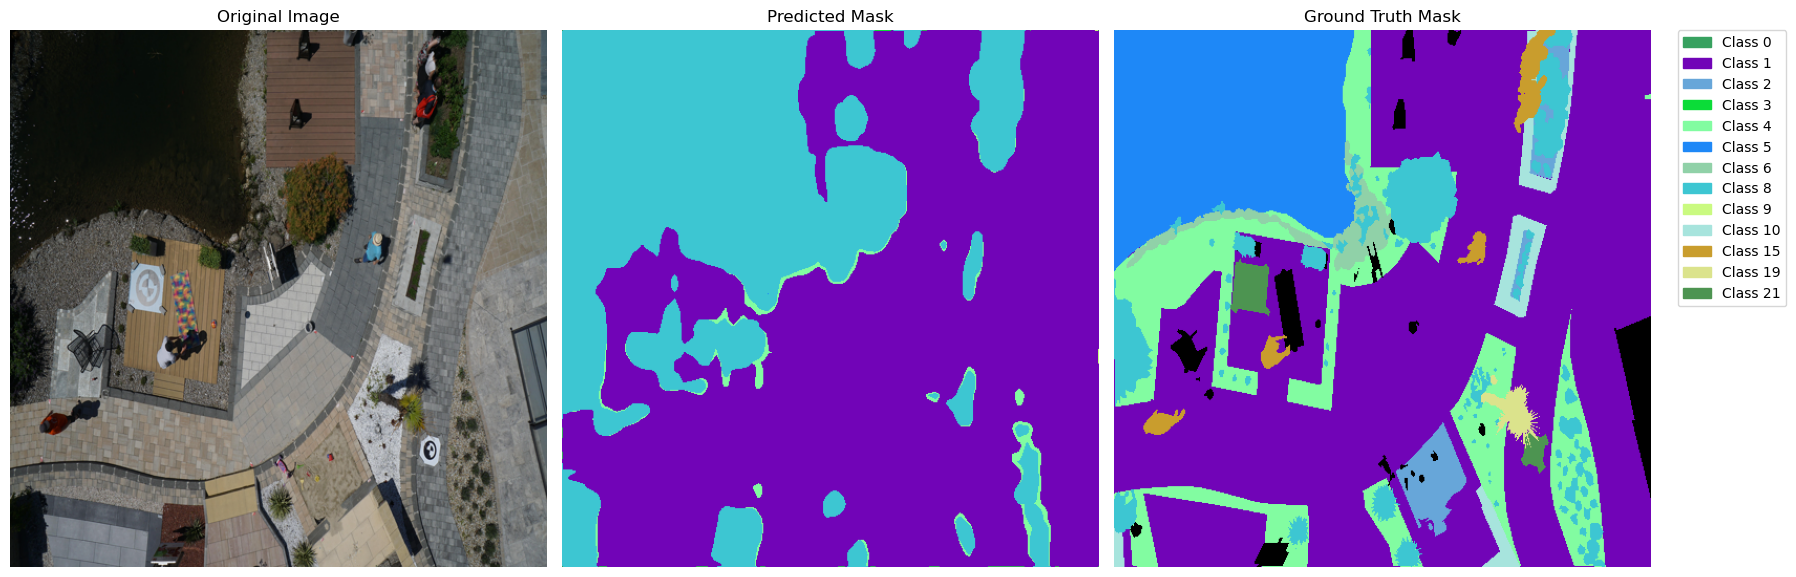

In [82]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def decode_segmentation_mask(mask, color_map):
    """Convert class-indexed mask to an RGB image."""
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for class_id, color in color_map.items():
        color_mask[mask == class_id] = color
    return color_mask

def visualize_pred_vs_truth(image, pred_mask, true_mask, class_names, class_colors):
    """Visualize original image, predicted mask, and true mask side-by-side."""
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy()
        image = (image * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # De-normalize
        image = np.clip(image * 255, 0, 255).astype(np.uint8)

    pred_color_mask = decode_segmentation_mask(pred_mask.numpy(), class_colors)
    true_color_mask = decode_segmentation_mask(true_mask.numpy(), class_colors)

    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(pred_color_mask)
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(true_color_mask)
    plt.title("Ground Truth Mask")
    plt.axis("off")

    # Create legend
    unique_ids = np.unique(np.concatenate([pred_mask.numpy().flatten(), true_mask.numpy().flatten()]))
    patches = [mpatches.Patch(color=np.array(class_colors[cls]) / 255, label=class_names[cls])
               for cls in unique_ids if cls in class_names]

    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout()
    plt.show()

# Run on one test sample
model.eval()
with torch.no_grad():
    for images, masks in test_dataloader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)['out']  # shape: (B, C, H, W)
        preds = torch.argmax(outputs, dim=1)  # shape: (B, H, W)

        # Visualize first sample in batch
        visualize_pred_vs_truth(images[0].cpu(), preds[0].cpu(), masks[0].cpu(), class_names, class_colors)
        break